# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

# Notebook 04 - Modeling and Assessment

## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
&nbsp;&nbsp;&nbsp;[1.1 Import the Needed Libraries](#import_libaries) <br>
&nbsp;&nbsp;&nbsp;[1.2 Define Functions](#functions) <br>
&nbsp;&nbsp;&nbsp;[1.3 Load the Data](#load_data) <br>
[2. Modeling and Evaluation](#modeling) <br>
&nbsp;&nbsp;&nbsp;[2.1 Baseline](#baseline) <br>
&nbsp;&nbsp;&nbsp;[2.2 Logistic Regression](#logistic_regression) <br>
&nbsp;&nbsp;&nbsp;[2.3 Naive Bayes](#nb) <br>
&nbsp;&nbsp;&nbsp;[2.4 K-Nearest Neighbors](#knn) <br>
&nbsp;&nbsp;&nbsp;[2.5 Decision Trees](#dt) <br>
&nbsp;&nbsp;&nbsp;[2.6 Random Forest Classifier](#random_forest) <br>
&nbsp;&nbsp;&nbsp;[2.7 Neural Networks](#nn) <br>
&nbsp;&nbsp;&nbsp;[2.8 XGBoost](#xgboost) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the Needed Libraries <a id='import_libaries'></a>

In [1]:
# Core Functions
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)
from scipy.stats import mode

# Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

# Model Selection
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Model Assessment
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set a global seed
np.random.seed(42)

### 1.2 Define Functions <a id='functions'></a>

In [23]:
# Define functions to use as pipeline

# Scaling
def scale_data(X_train, X_val):
    """Scale data using MinMaxScaler."""
    scaler = MinMaxScaler().fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_val)

# Training and Evaluation
def avg_score(model, X, y):
    """Evaluate a model using Stratified K-Fold Cross Validation."""
    skf = StratifiedKFold(n_splits=10)
    score_train, score_test, timer = [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # Scaling
        scaled_X_train, scaled_X_val = scale_data(X_train, X_val)
        # Include Encoding here?

        start = time.perf_counter()
        model.fit(scaled_X_train, y_train)
        end = time.perf_counter()

        score_train.append(f1_score(y_train, model.predict(scaled_X_train), average='macro'))
        score_test.append(f1_score(y_val, model.predict(scaled_X_val), average='macro'))

        timer.append(end - start)

    avg_time = round(np.mean(timer), 3)
    avg_train = round(np.mean(score_train), 3)
    avg_test = round(np.mean(score_test), 3)
    std_time = round(np.std(timer), 2)
    std_train = round(np.std(score_train), 2)
    std_test = round(np.std(score_test), 2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_test) + '+/-' + str(std_test)


def compare_results(models, X, y):
    """
    Evaluate multiple models using cross-validation and return results in a DataFrame.
    """
    results = []
    for name, model in models:
        print(f"Evaluating model: {name}...")
        avg_time, avg_train, avg_test = avg_score(model, X, y)
        results.append({
            "Model": name,
            "Avg Time (s)": avg_time,
            "Train F1-Score": avg_train,
            "Validation F1-Score": avg_test
        })

    results_df = pd.DataFrame(results)
    return results_df


# Hyperparameter Tuning
def hyperparameter_tuning(estimator, param_grid, X_train, y_train):
    """Perform hyperparameter tuning with GridSearchCV."""
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='f1_macro', cv=stratified_10_fold_cv)
    grid_search.fit(X_train, y_train)
    print(f"The best score is {grid_search.best_score_}")
    print(f"With the parameters: {grid_search.best_params_}")
    return grid_search.best_params_


# Evaluation Functions
def classification_report_print(y_test, y_pred, model):
    """Print classification report."""
    print("\nClassification Report for {}:".format(model))
    print('')
    print(classification_report(y_test, y_pred))

def conf_matrix_plot(y_true, y_pred, labels):
    """Plot confusion matrix."""
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    cnf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    df_cm = pd.DataFrame(cnf_matrix, index=unique_labels, columns=unique_labels)
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()



### 1.3 Load the Data <a id='load_data'></a>
[to the top](#top)

Replace the following lines of codes with the processed train and test files.

In [4]:
train_zip_path = 'train_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)

In [5]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


## 2. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

------------------ _DELETE THE FOLLOWING CODE FOR FINAL VERSION (UNTIL BASELINE), THIS IS JUST TO TEST IF THE FUNCTIONS WORK_ ------------------

In [6]:
# Example Dataset to test the functions
train_temp = train_df.copy()
train_temp = train_temp.drop(columns=['OIICS Nature of Injury Description', 'C-3 Date', 'First Hearing Date', 'IME-4 Count'])
train_temp = train_temp.dropna()
len(train_temp)

473997

In [7]:
# Split
train_data = train_temp.iloc[:140]  
val_data = train_temp.iloc[140:170]  
test_data = train_temp.iloc[170:200]

# Features and target
X_train = train_data.drop(columns=['Claim Injury Type'])
y_train = train_data['Claim Injury Type']

X_val = val_data.drop(columns=['Claim Injury Type'])
y_val = val_data['Claim Injury Type']

X_test = test_data.drop(columns=['Claim Injury Type'])
y_test = test_data['Claim Injury Type']

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 140
Validation size: 30
Test size: 30


In [8]:
# Encoding the target variable "Claim Injury Type"
target_encoder = LabelEncoder()
y_train_df_encode = target_encoder.fit_transform(y_train)
y_val_df_encode = target_encoder.transform(y_val)
y_test_df_encode = target_encoder.transform(y_test)

In [9]:
X_train_df_encode = X_train.copy()
one_hot_encode_columns = ['Gender', 'Attorney/Representative']
X_train_df_encode = pd.get_dummies(X_train_df_encode, columns=one_hot_encode_columns, drop_first=True)

desired_columns = ['Gender_M', 'Attorney/Representative_Y']
X_train_df_encode = X_train_df_encode[desired_columns]

# Validation - One-Hot-Encoding
X_val_df_encode = X_val.copy()
X_val_df_encode = pd.get_dummies(X_val_df_encode, columns=one_hot_encode_columns, drop_first=True)
X_val_df_encode = X_val_df_encode.reindex(columns=desired_columns, fill_value=0)

# Test - One-Hot-Encoding
X_test_df_encode = X_test.copy()
X_test_df_encode = pd.get_dummies(X_test_df_encode, columns=one_hot_encode_columns, drop_first=True)
X_test_df_encode = X_test_df_encode.reindex(columns=desired_columns, fill_value=0)

# Kontrolle der Ergebnisse
print("Train Shape:", X_train_df_encode.shape)
print("Validation Shape:", X_val_df_encode.shape)
print("Test Shape:", X_test_df_encode.shape)


Train Shape: (140, 2)
Validation Shape: (30, 2)
Test Shape: (30, 2)


In [10]:
X_train_df_encode = pd.DataFrame(X_train_df_encode)
y_train_df_encode = pd.Series(y_train_df_encode)

### 2.1 Baseline <a id='baseline'></a>
[to the top](#top)

As a baseline, we will just predict the majority class.

In [11]:
# Predict the majority class for all instances as baseline
majority_class = mode(y_train_df_encode)[0][0]  

y_pred_baseline = [majority_class] * len(y_train_df_encode)

baseline_f1 = f1_score(y_train_df_encode, y_pred_baseline, average='macro')
print(f"Baseline Model F1 Score (predicting majority class): {baseline_f1:.2f}")

y_pred_baseline_original = target_encoder.inverse_transform(y_pred_baseline)

# Classification report with the original labels
classification_report_print(y_train, y_pred_baseline_original, 'Baseline Model')

Baseline Model F1 Score (predicting majority class): 0.12

Classification Report for Baseline Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00         3
    2. NON-COMP       0.54      1.00      0.70        76
    3. MED ONLY       0.00      0.00      0.00         8
   4. TEMPORARY       0.00      0.00      0.00        32
5. PPD SCH LOSS       0.00      0.00      0.00        19
     6. PPD NSL       0.00      0.00      0.00         2

       accuracy                           0.54       140
      macro avg       0.09      0.17      0.12       140
   weighted avg       0.29      0.54      0.38       140



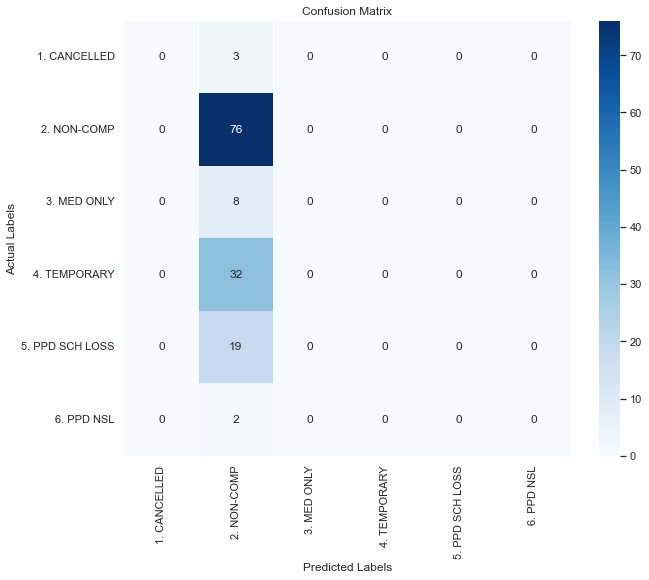

In [12]:
# Plot confusion matrix

labels=target_encoder.classes_
conf_matrix_plot(y_train, y_pred_baseline_original, labels)

### 2.2 Logistic Regression <a id='logistic_regression'></a>
[to the top](#top)

Step 1: Create model and define hyperparameter grid for Logistic Regression

In [16]:
# Create model
model_lr_default = LogisticRegression(multi_class='multinomial')
model_lr = LogisticRegression(multi_class='multinomial')

# Define hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength (smaller values mean stronger regularization)
    "solver": ["lbfgs", "saga", "newton-cg"],  # Solvers that support multinomial logistic regression
    "max_iter": [100, 500, 1000]  # Maximum number of iterations for solver convergence
}

Step 2: Perform hyperparameter tuning

In [14]:
# Tune hyperparameters using the training set
best_params_lr = hyperparameter_tuning(model_lr, param_grid, X_train_df_encode, y_train_df_encode)
model_lr.set_params(**best_params_lr)

The best score is 0.40064716939407335
With the parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}


LogisticRegression(C=10, multi_class='multinomial')

Step 3: Train default model and model with best parameter setting and evaluate

In [26]:
models_lr = [
    ("LR Default", model_lr_default),
    ("LR Best Params", model_lr)
]

In [29]:
# Train and evaluate using cross-validation on the train dataset
results_lr = compare_results(models_lr, X_train_df_encode, y_train_df_encode)
results_lr

Evaluating model: LR Default...
Evaluating model: LR Best Params...


,Model,Avg Time (s),Train F1-Score,Validation F1-Score
0,LR Default,0.003+/-0.0,0.292+/-0.01,0.418+/-0.12
1,LR Best Params,0.004+/-0.0,0.292+/-0.01,0.418+/-0.12


Step 4: Train the chosen model again on whole training set and evaluate on our Test Set

In [30]:
# Train and evaluate on the test set
model_lr.fit(X_train_df_encode, y_train_df_encode)
y_test_pred_lr = model_lr.predict(X_test_df_encode)

# Decode predictions
y_test_pred_decoded_lr = target_encoder.inverse_transform(y_test_pred_lr)

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_decoded_lr, 'Logistic Regression Model')


Classification Report for Logistic Regression Model:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00         1
    2. NON-COMP       0.55      0.85      0.67        13
    3. MED ONLY       0.00      0.00      0.00         4
   4. TEMPORARY       1.00      0.17      0.29         6
5. PPD SCH LOSS       0.33      0.60      0.43         5
     6. PPD NSL       0.00      0.00      0.00         1

       accuracy                           0.50        30
      macro avg       0.31      0.27      0.23        30
   weighted avg       0.49      0.50      0.42        30



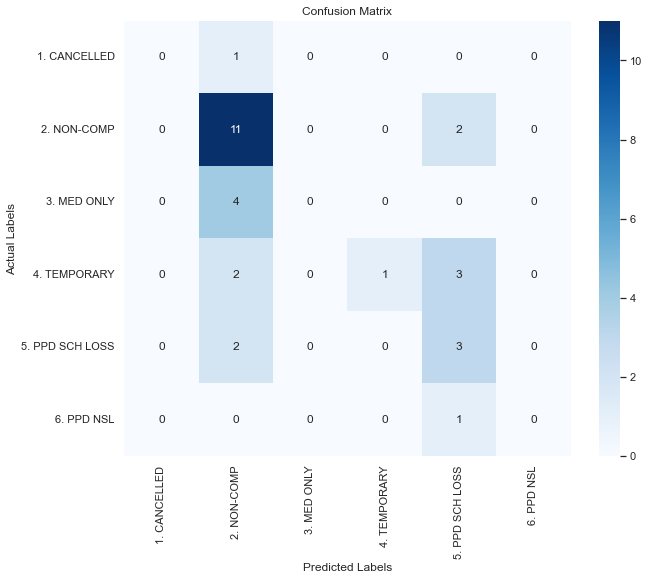

In [31]:
# Plot confusion matrix for validation data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_lr, labels)

__Findings:__
- __Dominant Predictions in Major Classes:__ The model tends to classify most instances as "NON-COMP" or "TEMPORARY," which may be due to the model biasing towards these dominant classes in order to maximize accuracy. This bias indicates that the model may not be capturing the nuances necessary to distinguish minority classes effectively.
- __Poor Performance in Minority Classes:__ For classes like "CANCELLED," "PTD," and "DEATH," the model struggles to make correct predictions. For example, "CANCELLED" instances are often misclassified as "NON-COMP," and the model almost never predicts "DEATH" correctly. This is problematic, as correct classification in these classes could be crucial depending on the application.
- __Overlapping Classes:__ There are high off-diagonal values indicating confusion between classes like "MED ONLY" and "TEMPORARY," and between "PPD SCH LOSS" and "TEMPORARY." This suggests that the model finds these classes challenging to differentiate, potentially due to similar feature distributions or because these categories have overlapping characteristics.

Step 5: Prediction on Submission Test Data

_NAME DIFFERENT SO WE DONT CONFUSE OUR TEST DATA WITH THE SUBMISSION TEST DATA_

In [80]:
# Predict on the test set
y_test_pred_lr = model_lr.predict(X_test_df_encode)
y_test_decoded_lr = target_encoder.inverse_transform(y_test_pred_lr)
y_test_decoded_lr

array(['2. NON-COMP', '2. NON-COMP', '5. PPD SCH LOSS', '2. NON-COMP',
       '5. PPD SCH LOSS', '2. NON-COMP', '2. NON-COMP', '2. NON-COMP',
       '2. NON-COMP', '2. NON-COMP', '2. NON-COMP', '2. NON-COMP',
       '2. NON-COMP', '2. NON-COMP', '5. PPD SCH LOSS', '5. PPD SCH LOSS',
       '5. PPD SCH LOSS', '5. PPD SCH LOSS', '5. PPD SCH LOSS',
       '5. PPD SCH LOSS', '2. NON-COMP', '2. NON-COMP', '2. NON-COMP',
       '4. TEMPORARY', '2. NON-COMP', '5. PPD SCH LOSS', '2. NON-COMP',
       '2. NON-COMP', '2. NON-COMP', '2. NON-COMP'], dtype=object)

In [81]:
unique_values, counts = np.unique(y_test_decoded_lr, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 20
4. TEMPORARY: 1
5. PPD SCH LOSS: 9


In [307]:
# Create a submission DataFrame
submission_lr = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_lr
})

# Save the submission file
submission_lr.to_csv('submission_lr.csv', index=False)
print("Submission file saved as 'submission_lr.csv'")

Submission file saved as 'submission_lr.csv'


In [308]:
submission_lr

,Claim Identifier,Prediction
0,6165911,2. NON-COMP
1,6166141,2. NON-COMP
2,6165907,2. NON-COMP
3,6166047,2. NON-COMP
4,6166102,2. NON-COMP
...,...,...
387970,6553137,2. NON-COMP
387971,6553119,2. NON-COMP
387972,6553542,2. NON-COMP
387973,6553455,2. NON-COMP


### 2.3 Naive Bayes <a id='nb'></a>
[to the top](#top)

In [ ]:
# Create model
model_nb = MultinomialNB()

# Define hyperparameter grid
param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 100],  # Laplace smoothing parameter
    "fit_prior": [True, False]         # Whether to learn class priors or use uniform distribution
}

### 2.4 K-Nearest Neighbor <a id='knn'></a>
[to the top](#top)

In [ ]:
# Create KNN model
model_knn = KNeighborsClassifier()

# Define parameter grid
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

### 2.5 Decision Trees <a id='dt'></a>
[to the top](#top)

In [ ]:

# Create Decision Tree model
model_dt = DecisionTreeClassifier()

# Define hyperparameter grid
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"], # Impurity measure
    "splitter": ["best", "random"],               # Split strategy
    "max_depth": [None, 5, 10, 20, 50],           # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],              # Minimum samples required to split an internal node
    "min_samples_leaf": [1, 2, 5, 10],            # Minimum samples required in a leaf node
    "max_features": [None, "sqrt", "log2"],       # Number of features to consider for best split
    "max_leaf_nodes": [None, 10, 20, 50, 100]     # Maximum number of leaf nodes
}

### 2.6 Random Forest Classifier <a id='random_forest'></a>
[to the top](#top)

Step 1: Create models and define hyperparameter grid for Random Forest Classifier

In [32]:
# Create model
model_rf_default = RandomForestClassifier()
model_rf = RandomForestClassifier()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

Step 2: Perform hyperparameter tuning

In [33]:
# Tune hyperparameters using the training set
best_params_rf = hyperparameter_tuning(model_rf, param_grid, X_train_df_encode, y_train_df_encode)
model_rf.set_params(**best_params_rf)

The best score is 0.40064716939407335
With the parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50)

Step 3: Train model with best parameter setting and evaluate

In [36]:
models_rf = [
    ("RF Default", model_rf_default),
    ("RF Best Params", model_rf)
]

In [37]:
# Train and evaluate using cross-validation on the train dataset
results_rf = compare_results(models_rf, X_train_df_encode, y_train_df_encode)
results_rf

Evaluating model: RF Default...
Evaluating model: RF Best Params...


,Model,Avg Time (s),Train F1-Score,Validation F1-Score
0,RF Default,0.068+/-0.01,0.292+/-0.01,0.418+/-0.12
1,RF Best Params,0.033+/-0.0,0.292+/-0.01,0.418+/-0.12


Step 4: Train the chosen model again on whole training set and evaluate on our Test Set

In [38]:
# Train and evaluate on the test set
model_rf.fit(X_train_df_encode, y_train_df_encode)
y_test_pred_rf = model_rf.predict(X_test_df_encode)

# Decode predictions
y_test_pred_decoded_rf = target_encoder.inverse_transform(y_test_pred_rf)

# Classification report with the original labels
classification_report_print(y_test, y_test_pred_decoded_rf, 'Random Forrest Classifier')


Classification Report for Random Forrest Classifier:

                 precision    recall  f1-score   support

   1. CANCELLED       0.00      0.00      0.00         1
    2. NON-COMP       0.55      0.85      0.67        13
    3. MED ONLY       0.00      0.00      0.00         4
   4. TEMPORARY       1.00      0.17      0.29         6
5. PPD SCH LOSS       0.33      0.60      0.43         5
     6. PPD NSL       0.00      0.00      0.00         1

       accuracy                           0.50        30
      macro avg       0.31      0.27      0.23        30
   weighted avg       0.49      0.50      0.42        30



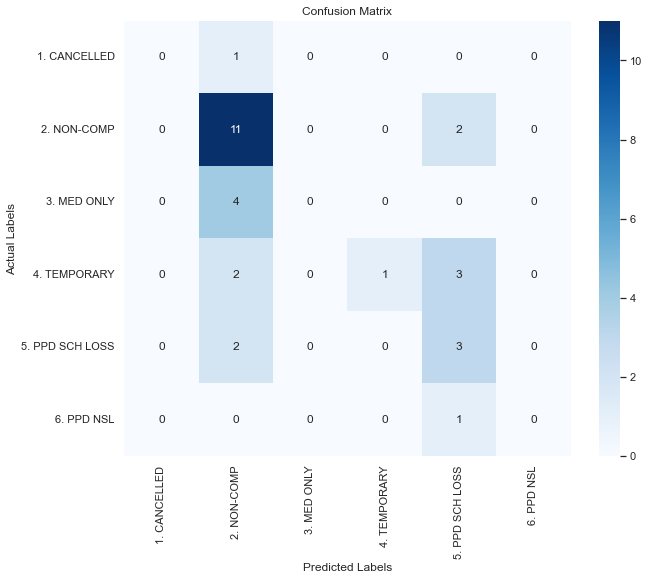

In [39]:
# Plot confusion matrix for validation data
labels=target_encoder.classes_
conf_matrix_plot(y_test, y_test_pred_decoded_rf, labels)

__Findings:__
- __Improvement in Certain Classes:__ The random forest classifier is showing better predictions for classes like "CANCELLED" and "TEMPORARY," as evidenced by more instances being correctly classified. For instance, 975 instances of "CANCELLED" and 130,497 instances of "TEMPORARY" are correctly predicted, which is an improvement over the logistic regression results.
- __Persistent Bias Toward Majority Classes:__ Similar to the logistic regression model, the random forest is heavily biased towards the majority class, "NON-COMP." It classifies a large number of instances into this category, which may indicate that the model still struggles with the imbalanced distribution of classes.
- __Challenges with Rare Classes:__ Similar to the logistic regression model, the random forest struggles with rare classes like "PPD NSL," "PTD," and "DEATH." These classes have very few correct predictions, indicating that the model has not learned to recognize their unique patterns well. This might be due to the insufficient representation of these classes in the training data

Step 5: Prediction on Submission Test Data

In [89]:
y_test_pred_rf = model_rf.predict(X_test_df_encode)
y_test_decoded_rf = target_encoder.inverse_transform(y_test_pred_rf)
y_test_decoded_rf

array(['2. NON-COMP', '2. NON-COMP', '5. PPD SCH LOSS', '2. NON-COMP',
       '5. PPD SCH LOSS', '2. NON-COMP', '2. NON-COMP', '2. NON-COMP',
       '2. NON-COMP', '2. NON-COMP', '2. NON-COMP', '2. NON-COMP',
       '2. NON-COMP', '2. NON-COMP', '5. PPD SCH LOSS', '5. PPD SCH LOSS',
       '5. PPD SCH LOSS', '5. PPD SCH LOSS', '5. PPD SCH LOSS',
       '5. PPD SCH LOSS', '2. NON-COMP', '2. NON-COMP', '2. NON-COMP',
       '4. TEMPORARY', '2. NON-COMP', '5. PPD SCH LOSS', '2. NON-COMP',
       '2. NON-COMP', '2. NON-COMP', '2. NON-COMP'], dtype=object)

In [90]:
unique_values, counts = np.unique(y_test_decoded_rf, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

2. NON-COMP: 20
4. TEMPORARY: 1
5. PPD SCH LOSS: 9


In [317]:
# Create a submission DataFrame
submission_rf = pd.DataFrame({
    'Claim Identifier': test_df['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': y_test_decoded_rf
})

# Save the submission file
submission_rf.to_csv('submission_rf.csv', index=False)
print("Submission file saved as 'submission_rf.csv'")

Submission file saved as 'submission_rf.csv'


### 2.7 Neural Networks <a id='nn'></a>
[to the top](#top)

### 2.8 XGBoost <a id='xgboost'></a>
[to the top](#top)